# 2.0 Generating Human Datasets

# Initial Setup

## Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [1]:
# Load `watermark` extension
%load_ext watermark

In [2]:
# Display the status of the machine and other non-code related info
%watermark -m -g -b -h

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 5.15.0-119-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

Hostname: apra-desktop-ubuntu

Git hash: bda4f9ff047b0acbd61850f4d9bb32fd7c1e6a0c

Git branch: human



Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [3]:
# Load `autoreload` extension
%load_ext autoreload

In [4]:
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [5]:
# Set the matplotlib mode
%matplotlib inline

## Imports

In [9]:
# Standard library imports
from pathlib import Path
from datetime import datetime

# Third party
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from loguru import logger

%aimport hmdcpd.visualization
%aimport hmdcpd.analysis
from hmdcpd import (
    visualization, 
    analysis,
)

%aimport bouncing_ball_task.bouncing_ball
%aimport bouncing_ball_task.human_bouncing_ball
%aimport bouncing_ball_task.utils.pyutils
%aimport bouncing_ball_task.utils.taskutils
%aimport bouncing_ball_task.utils.visualize
%aimport bouncing_ball_task.utils.gif
from bouncing_ball_task.utils import pyutils, visualize, gif
from bouncing_ball_task import human_bouncing_ball as hbb
from bouncing_ball_task import index

# Display  versions of everything
%watermark -v -iv

Python implementation: CPython
Python version       : 3.12.6
IPython version      : 8.27.0

numpy             : 2.1.1
bouncing_ball_task: 0.0.0
seaborn           : 0.13.2
pandas            : 2.2.3
cv2               : 4.10.0
matplotlib        : 3.9.2



In [10]:
# Suppress sci notation
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Function Definitions

In [11]:
def plot_effective_stats(df_data):
    # Create the subplots
    palette = visualize.get_color_palette(
        ["Low", "High"],
        (("Blues", 1), ("Reds", 1)),
        linspace_range=(0.75, 1),
    )
    palette_trial = visualize.get_color_palette(
        ["Straight", "Catch", "Bounce"],
        (("Blues", 1), ("Wistia", 1), ("Reds", 1)),
        linspace_range=(0.75, 1),
    )
    palette_contingency = visualize.get_color_palette(
        ["Low", "Medium", "High"],
        (("Blues", 1), ("Wistia", 1), ("Reds", 1)),
        linspace_range=(0.75, 1),
    )
    
    plot_params = [
        [
            (
                "PCCNVC_effective",
                "Observed Hazard Rates",
                "Effective Hazard Rate Bins",
                {
                    "hue": "Hazard Rate",
                    "legend": False,
                    "palette": palette,
                }
            ),
            (
                "Color Change Random",
                "Number of Random Color Changes",
                "Random Color Change Bins",
                {
                    "hue": "Hazard Rate",
                    "legend": True,
                    "discrete": True,
                    "palette": palette,
                }
            ),
            (
                "length",
                "Distribution of Video Lengths",
                "Video Length Bins",
                {
                    "hue": "trial",
                    "legend": True,
                    "palette": palette_trial,
                }
            ),
        ],
        [
            (
                "PCCOVC_effective",
                "Observed Trial Contingency",
                "Effective Contingency Bins",
                {
                    "hue": "Contingency",
                    "palette": palette_contingency,
                    "legend": False,
                },
            ),
            (
                "Color Change Bounce",
                "Number of Bounce Color Changes",
                "Bounce Color Changes",
                {
                    "discrete": True,
                    "hue": "Contingency",
                    "palette": palette_contingency,
                    "legend": True,
                }
            ),
            (
                "Bounces",
                "Number of Bounces",
                "Number of Bounces",
                {
                    "discrete": True,
                    "hue": "trial",
                    "palette": palette_trial,
                    "legend": True,
                }
            ),
        ],
    ]
    
    rows = 2
    fig, axes = plt.subplots(
        rows,
        len(plot_params[0]),
        figsize=(len(plot_params[0])*4, rows*4),
    )
    
    for i, row_plots in enumerate(plot_params):
        for j, (col, title, xlabel, plot_dict) in enumerate(row_plots):
            ax = axes[i, j]
            sns.histplot(
                df_data,
                x=col,
                ax=ax,
                **plot_dict,
            )
            ax.set_title(title)
            ax.set_xlabel(xlabel)
            if j != 0:
                ax.set_ylabel(None)
    
    plt.suptitle(f"Task Statstics for {batch_size} Videos")
    plt.tight_layout()
    plt.show()

# Loading Task Instance

In [46]:
# Task Parameters
batch_size = None
human_video_parameters = {
    "size_frame": (size_frame := (256, 256)),
    "ball_radius": (ball_radius := 10),
    "dt": (dt := 0.1),
    "total_dataset_length": (total_dataset_length := 5),
    # "total_videos": (batch_size := 10000),
    "mask_center": (mask_center := 0.5),
    "mask_fraction": (mask_fraction := 1 / 3),
    "velocity_lower": (velocity_lower := 1 / 12.5),
    "velocity_upper": (velocity_upper := 1 / 7.5),
    "num_y_velocities": (num_y_velocities := 2),
    "pccnvc_lower": (pccnvc_lower := 0.0065),
    "pccnvc_upper": (pccnvc_upper := 0.0575),
    "pccovc_lower": (pccovc_lower := 0.025),
    "pccovc_upper": (pccovc_upper := 0.975),
    "num_pccnvc": (num_pccnvc := 2),
    "num_pccovc": (num_pccovc := 3),
    "pvc": (probability_velocity_change := 0.0),
    "num_pos_endpoints": (num_pos_endpoints := 5),
    "p_catch_trials": (p_catch_trials := 0.05),
    "bounce_offset": (bounce_offset := 2/5),
    "border_tolerance_outer": (border_tolerance_outer := 1.25),
    "border_tolerance_inner": (border_tolerance_inner := 1.0),
    "bounce_straight_split": (bounce_straight_split := 0.5),
    "use_logger": False,
    "print_stats": True,
}

task_parameters = {
    "size_frame": size_frame,
    "ball_radius": ball_radius,
    "target_future_timestep": (target_future_timestep := 0),
    "dt": dt,
    "sample_mode": (sample_mode := "parameter_array"),
    "target_mode": (target_mode := "parameter_array"),
    "mask_center": mask_center,
    "mask_fraction": mask_fraction,
    "mask_color": (mask_color := [127, 127, 127]),
    "sequence_mode": (sequence_mode := "reverse"),
    "debug": (debug := True),
    "sample_velocity_discretely": (sample_velocity_discretely := True),
    "return_change": (return_change := True),
    "return_change_mode": (return_change_mode := "source"),
    "min_t_color_change": (min_t_color_change := 15),
    "color_mask_mode": (color_mask_mode := "fade"),
    "initial_timestep_is_changepoint": (initial_timestep_is_changepoint := False),
}

size_x, size_y = size_frame

task, list_samples, list_targets, df_data, dict_metadata = hbb.generate_video_dataset(
    human_video_parameters,
    task_parameters,
    shuffle=False,
    num_blocks=5,
)
mask_start = task.mask_start
mask_end = task.mask_end
mask_color = task.mask_color
samples = task.samples
targets = task.targets

if batch_size is None:
    batch_size = samples.shape[0]

df_metadata_trials_straight = df_data[
    df_data["trial"] == "Straight"
]
df_metadata_trials_bounce = df_data[
    df_data["trial"] == "Bounce"
]

2024-10-17 13:55:39.298 | DEBUG    | bouncing_ball_task.bouncing_ball:color_mask_mode:486 - Running color_mask_mode setter
2024-10-17 13:55:39.299 | DEBUG    | bouncing_ball_task.bouncing_ball:transitioning_change_mode:464 - Running transitioning_change_mode setter
2024-10-17 13:55:39.299 | DEBUG    | bouncing_ball_task.bouncing_ball:sequence_mode:419 - Running sequence_mode setter
2024-10-17 13:55:39.300 | DEBUG    | bouncing_ball_task.bouncing_ball:resample_change_probabilities:512 - Running resample_change_probabilities
2024-10-17 13:55:39.301 | DEBUG    | bouncing_ball_task.bouncing_ball:color_sampling:396 - Running color_sampling setter
2024-10-17 13:55:39.302 | DEBUG    | bouncing_ball_task.bouncing_ball:return_change_mode:450 - Running return_change_mode setter


Dataset Generation Summary
  Num Total Trials: 32 (4 min 48.4 sec)
    length_trials_ms:       288405
    video_length_min_ms:    8010
    video_length_max_ms:    11250
    video_length_min_f:     178
    video_length_max_f:     250
    ball_radius:            10
    dt:                     0.1
    duration:               45
    exp_scale:              1.0
    border_tolerance_outer: 1.25
    mask_center:            0.5
    mask_fraction:          0.3333333333333333
    size_x:                 256
    size_y:                 256
    num_pos_endpoints:      5
    pvc:                    0.0
    num_y_velocities:       2
    bounce_offset:          0.4
  Num Catch Trials: 1 (0 min 8.0 sec)
    Min Video Length (s):  8.0
    Max Video Length (s):  8.0
    Color Splits:          [np.float64(1.0)]
    pccnvc Splits:         [np.float64(1.0)]
    pccovc Splits:         [np.float64(1.0)]
    Stat Comb Splits:      [np.float64(1.0)]
  Num Straight Trials: 15 (2 min 19.9 sec)
    Min Video Leng

In [48]:
df_data["Block Video"]

Video ID
0     3
1     1
2     5
3     7
4     7
5     1
6     5
7     6
8     2
9     2
10    4
11    6
12    1
13    4
14    3
15    3
16    4
17    5
18    1
19    4
20    3
21    2
22    2
23    6
24    1
25    5
26    3
27    2
28    5
29    6
30    4
31    6
Name: Block Video, dtype: int64

# Plots

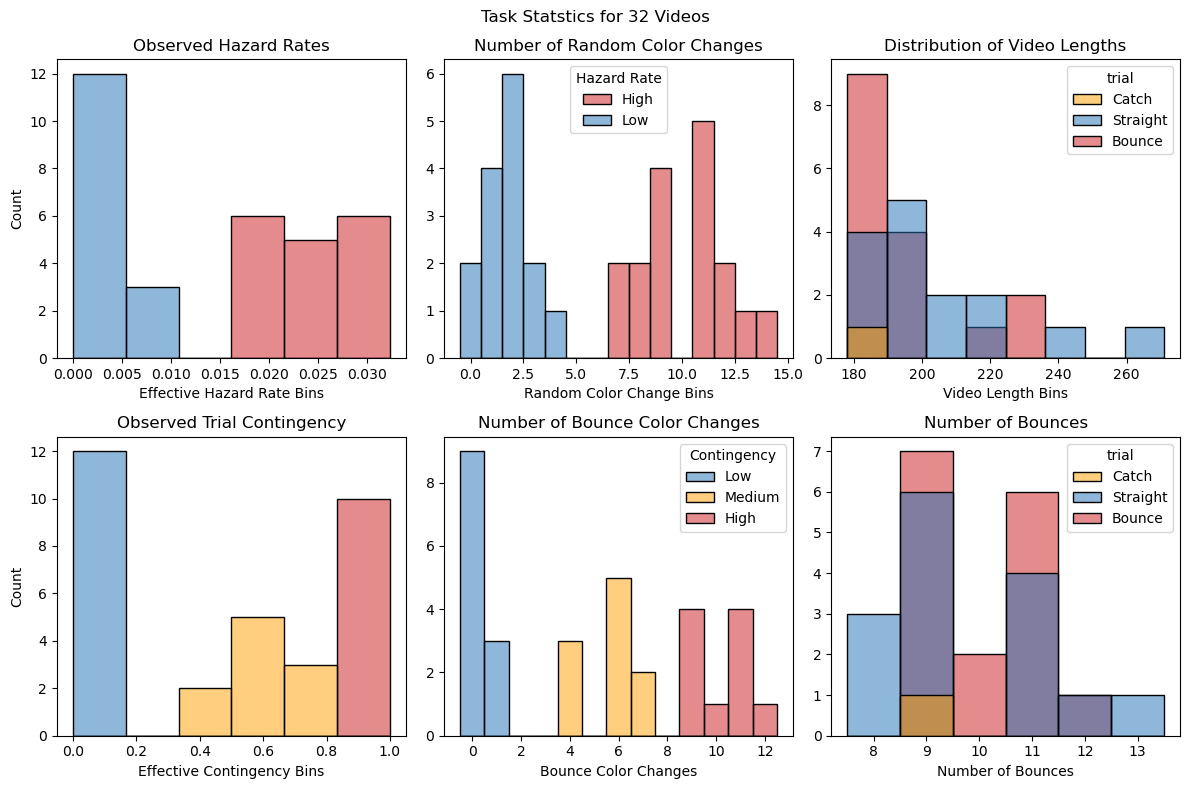

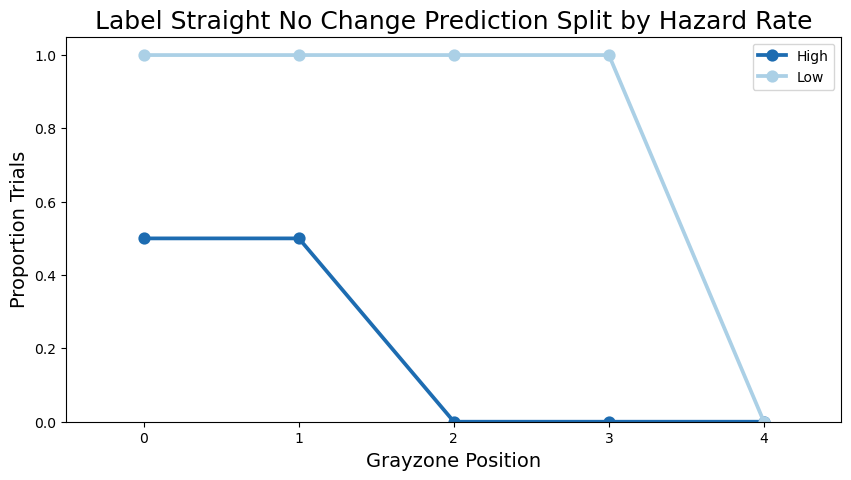

In [18]:
plot_effective_stats(df_data)

df_nested_position_counts_straight_hazard_label_straight = analysis.response_nested_no_change_prediction_counts(
    df_metadata_trials_straight,
    df_metadata_trials_straight,
    groupby_outer='Hazard Rate',
    label_func_outer=lambda x: x,
    label_title_outer="Hazard Rate",
    groupby_inner='idx_time',
    label_func_inner=lambda pos: str(pos),
    label_title_inner="Grayzone Position",
    as_df=True,
    response_column='correct_response',
)

title = "Label Straight No Change Prediction Split by Hazard Rate"
visualization.plot_color_prediction_counts(
    df_nested_position_counts_straight_hazard_label_straight,
    title,
    hue="Hazard Rate",
    x="Grayzone Position",
    y="No Change",
    palette_labels=["Low", "High"],
    palette_color_counts=(("Blues", 2),),
    palette_linspace_range=(0.333, 1.2),
    plot=sns.pointplot,
    # legend_loc=legend_loc,
)
plt.show()

# Saving the Dataset

In [32]:
df_data["trial"][0]

'Catch'

In [20]:
# task, list_samples, list_targets, df_data, dict_metadata
df_data

,idx_trial,trial,idx_time,side_left_right,side_top_bottom,idx_velocity_y,idx_x_position,idx_y_position,length,Final Color,...,correct_response,PCCNVC_effective,PCCOVC_effective,PVC_effective,Bounces,Random Bounces,Color Change Bounce,Color Change Random,Hazard Rate,Contingency
Video ID,,,,,,,,,,,,,,,,,,,,,
0,0,Catch,-1,-1,-1,-1,-1,-1,178,blue,...,3,0.02261,0.11111,0.00000,9,0,1,9,High,Low
1,0,Straight,0,0,1,0,-1,-1,183,red,...,1,0.00496,0.00000,0.00000,9,0,0,2,Low,Low
2,1,Straight,1,0,0,0,-1,-1,213,green,...,2,0.03233,0.44444,0.00000,9,0,4,14,High,Medium
3,2,Straight,2,1,1,1,-1,-1,200,blue,...,3,0.01914,1.00000,0.00000,11,0,11,8,High,High
4,3,Straight,3,1,0,1,-1,-1,187,blue,...,3,0.00247,0.00000,0.00000,11,0,0,1,Low,Low
5,4,Straight,4,1,0,0,-1,-1,198,red,...,1,0.00716,0.50000,0.00000,8,0,4,3,Low,Medium
6,5,Straight,0,1,0,1,-1,-1,271,green,...,2,0.02669,0.92308,0.00000,13,0,12,13,High,High
7,6,Straight,1,0,1,1,-1,-1,191,green,...,2,0.02689,0.09091,0.00000,11,0,1,11,High,Low
8,7,Straight,2,0,1,1,-1,-1,192,blue,...,3,0.00732,0.54545,0.00000,11,0,6,3,Low,Medium


In [14]:
dir_base = index.dir_data
name_dataset = "hbb_dataset_" + datetime.now().strftime("%y%m%d_%H%M%S")
dir_dataset = dir_base / name_dataset
dir_all_videos = dir_dataset / "videos"


# Add some extra parameters to the metadata
dict_metadata["name"] = name_dataset
dict_metadata["min_t_color_change"] = min_t_color_change


num_params = sum(len(param) for param in params)
if args.total_videos is not None:
    assert num_params == args.total_videos

if args.sequence_length is None:
    max_length = meta_dataset["video_length_max_f"]
else:
    max_length = args.sequence_length

params_blocks = generate_block_parameters(
    params,
    args.num_blocks,
    shuffle_block=True,
    shuffle_block_elements=True,
)


NameError: name 'params' is not defined